# Spread of COVID-19 in Mumbai

## Introduction

Mumbai is a densely populated city with an agile and active life style and has seen a consistent growth in COVID-19 cases over the last many months. The objective behind this exercise is to understand how the COVID-19 Positive cases have spread across Mumbai and the relationship the same has with various elements like location data i.e. venues of interest, geographical and population related parameters with the goal of arriving at few observations and high level insights that may be of help in fine tuning the actions being taken by the Government in combating this disease.

As part of this assignment, we explore, segment and cluster the Wards in the city of Mumbai. We utilize a web page to read in Population and related data. We scrape this web page to extract data and then read it into a pandas dataframe. We also gather COVID-19 data for Mumbai by leveraging a Dashboard maintained by the Municipal Corporation of Greater Mumbai.

We convert Ward and Area names into their equivalent latitude and longitude values and use the Foursquare API to explore the Wards in Mumbai. We get the most common venue categories in each Ward, and then group them into clusters by using the *k*-means clustering algorithm. Finally, the Folium library is used to visualize the Wards in Mumbai and their emerging clusters.

#### Let's ensure to install all the dependent components first

In [1]:
%%capture
# Ignore command line output
!conda install -c anaconda lxml --yes
!conda install -c anaconda html5lib
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes

We import all the libraries needed for this program

In [2]:
import numpy as np
import pandas as pd
from lxml import html # For reading html pages
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
import requests # library to handle requests
import time
import math
from sklearn.cluster import KMeans # import k-means from clustering stage
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display

## Download and Explore Dataset

Let's download the web page by using the Pandas library. Pandas reads in the web page as a list. The second element in this list is the dataframe with the actual data that we need.

In [3]:
url = 'http://www.demographia.com/db-mumbaidistr91.htm'
mum_wards_wiki = pd.read_html(url)

In [4]:
mum_wards = mum_wards_wiki[1].copy()
display(mum_wards.head())
display(mum_wards.shape)

,0,1,2,3,4,5,6
0,WARDS,NaN,NaN,NaN,NaN,NaN,NaN
1,Ward,Area,Land Area (SKM),Households,Population,Density per Square Kilometer,Density per Square Mile
2,ISLAND CITY DISTRICT,ISLAND CITY DISTRICT,76.8,677354,3338031,43447,112528
3,A,Colaba,12.5,43661,210847,16868,43687
4,B,Sanhurst Road,2.5,27225,140633,56936,147465


(38, 7)

Let's drop rows with data that are not of interest to us

In [5]:
mum_wards.drop(mum_wards.loc[mum_wards[0] == 'WARDS'].index, axis = 0, inplace = True)
mum_wards.drop(mum_wards.loc[mum_wards[0] == 'ISLAND CITY DISTRICT'].index, axis = 0, inplace = True)
mum_wards.drop(mum_wards.loc[mum_wards[0] == 'SUBURBAN DISTRICT'].index, axis = 0, inplace = True)
mum_wards.reset_index(drop = True, inplace = True)
ndx = mum_wards.loc[mum_wards[0] == 'MUNICIPALITY OF GREATER MUMBAI'].index[0]
mum_wards.drop(mum_wards[ndx:].index, axis = 0, inplace = True)

display(mum_wards.shape)

(25, 7)

Columns renamed by using names extracted from the table / DataFrame

In [6]:
if len(mum_wards.loc[mum_wards.iloc[:, 0] == 'Ward'].values) > 0:
    cols = mum_wards.loc[mum_wards[0] == 'Ward'].index[0]
    mum_wards.columns = mum_wards.loc[cols]
    mum_wards.drop(mum_wards.loc[mum_wards.iloc[:, 0] == 'Ward'].index, axis = 0, inplace = True)
    mum_wards.reset_index(drop = True, inplace = True)
display(mum_wards.head(3))
print(mum_wards.shape)

,Ward,Area,Land Area (SKM),Households,Population,Density per Square Kilometer,Density per Square Mile
0,A,Colaba,12.5,43661,210847,16868,43687
1,B,Sanhurst Road,2.5,27225,140633,56936,147465
2,C,Marine Lines,1.8,39657,202922,114001,295263


(24, 7)


Convert all the data needed into numerical types and enable the use of the same for computation later and drop 'Density per Square Mile' as 'Density per Square Kilometer' will suffice

In [7]:
mum_wards['Land Area (SKM)'] = mum_wards['Land Area (SKM)'].astype('float64')
mum_wards['Households'] = mum_wards['Households'].astype('int')
mum_wards['Population'] = mum_wards['Population'].astype('int')
mum_wards['Density per Square Kilometer'] = mum_wards['Density per Square Kilometer'].astype('int')
mum_wards = mum_wards.drop('Density per Square Mile', 1)

In [8]:
display(mum_wards.head(2))
display(mum_wards.tail(2))

,Ward,Area,Land Area (SKM),Households,Population,Density per Square Kilometer
0,A,Colaba,12.5,43661,210847,16868
1,B,Sanhurst Road,2.5,27225,140633,56936


,Ward,Area,Land Area (SKM),Households,Population,Density per Square Kilometer
22,S,Bhandup,64.0,148731,691227,10800
23,T,Mulund,45.4,73540,330195,7270


Let's first convert the Ward and/or Area name to latitude and longitude as this is a prerequisite to utilize the Foursquare location data.

We attempt several different lookup of the Ward and Area name so that the Nominatim library is able to pick up valid Geographical coorindates for the Wards from the OpenStreetMap

In [9]:
geolocator = Nominatim(user_agent="Mumbai_Exp")

# Rectangular boundaries of Mumbai - Larger than the actual area, but helps in bounds checking
MN_Lat, MN_Long = 19.271826, 72.849824
MS_Lat, MS_Long = 18.891997, 72.808479
ME_Lat, ME_Long = 19.152063, 72.980973
MW_Lat, MW_Long = 18.945585, 72.785820

ward_lat = []
ward_long = []

for ward, w_area in zip(list(mum_wards['Ward']), list(mum_wards['Area'])):

    # Handle few exception scenarios to start with
    # Add Road to Elphinstone to ensure you are picking up the right place for the lookup
    if w_area != "Elphinstone":
        area = w_area
    else:
        area = w_area + " Road"
               
    # Compose the name of the place by using the name of the area for the Geo co-ordinate lookup
    address = area + ", " + "Mumbai"
    
    try:
        location = geolocator.geocode(address)
    except:
        location = None
    
    # Validate coordinates against the rectangular boundaries
    if location != None:
        lat = location.latitude
        long = location.longitude
        if (lat < MS_Lat or lat > MN_Lat):
            location = None
        elif (long < MW_Long or long > ME_Long):
            location = None
      
    # If the lookup did not succeed, recompose the name by appending the string "Ward" to the area name
    if location == None:
        address = area + ", Ward " + ward + ", "  + "Mumbai"
        
        try:
            location = geolocator.geocode(address)
        except:
            location = None
        
        if location != None:
            lat = location.latitude
            long = location.longitude
            # Validate coordinates
            if (lat < MS_Lat or lat > MN_Lat):
                location = None
            elif (long < MW_Long or long > ME_Long):
                location = None
        else:
            lat = 0
            long = 0
            
    # if the above fails as well, let's try with only the 'Ward' prefixed to the ward name
    if location == None:
        address = ward + ' Ward' + ", "  + "Mumbai"
        
        try:
            location = geolocator.geocode(address)
        except:
            location = None

        # Validate coordinates
        if location != None:
            lat = location.latitude
            long = location.longitude
            if (lat < MS_Lat or lat > MN_Lat):
                location = None
            elif (long < MW_Long or long > ME_Long):
                location = None

        # if the above fails as well, let's try with only the 'Ward' suffixed to the ward name
        if location == None:
            address = 'Ward ' + ward + ", " + "Mumbai"
            
            try:
                location = geolocator.geocode(address)
            except:
                location = None
                
            if location != None:
                lat = location.latitude
                long = location.longitude
            else:
                lat = 0
                long = 0

    # Hopefully we found a reasonably valid information on the location
    ward_lat += [lat]
    ward_long += [long]
    print('The geograpical coordinate of {} are {}, {}.'.format(address, lat, long))

The geograpical coordinate of Colaba, Mumbai are 18.915091, 72.8259691.
The geograpical coordinate of B Ward, Mumbai are 18.95630985, 72.83983833156506.
The geograpical coordinate of Marine Lines, Mumbai are 18.9456701, 72.823781.
The geograpical coordinate of Grant Road, Mumbai are 18.9644472, 72.8135727.
The geograpical coordinate of Byculla, Mumbai are 18.9766219, 72.8327936.
The geograpical coordinate of Parel, Mumbai are 19.0094817, 72.8376614.
The geograpical coordinate of Matunga, Mumbai are 19.0274356, 72.8501467.
The geograpical coordinate of Elphinstone Road, Mumbai are 19.0084268, 72.842505.
The geograpical coordinate of Dadar/Plaza, Mumbai are 19.02376705, 72.8394033818551.
The geograpical coordinate of Khar/Santacruz, Mumbai are 19.083966, 72.8416986.
The geograpical coordinate of Bandra, Mumbai are 19.0549792, 72.8402203.
The geograpical coordinate of Andheri (East), Mumbai are 19.1158835, 72.854202.
The geograpical coordinate of Andheri (West), Mumbai are 19.1172495, 72.

Let's create a copy of the Mumbai Wards dataframe and merge the latitude and longitude from the above dataframe.

We drop 'Density per Square Kilometer' and 'Households' as these are redundant. The Density is a function of Population and Land Area and Households directly relates to Population.

In [10]:
mum_upd_wards = mum_wards.copy()

In [11]:
# mum_upd_wards_df['Latitude', 'Longitude'] = ward_lat, ward_long
mum_upd_wards['Latitude'] = ward_lat
mum_upd_wards['Longitude'] = ward_long
mum_upd_wards = mum_upd_wards.drop('Density per Square Kilometer', 1)
mum_upd_wards = mum_upd_wards.drop('Households', 1)

In [12]:
display(mum_upd_wards.head(2))
display(mum_upd_wards.shape)

,Ward,Area,Land Area (SKM),Population,Latitude,Longitude
0,A,Colaba,12.5,210847,18.915091,72.825969
1,B,Sanhurst Road,2.5,140633,18.956310,72.839838


(24, 6)

Drop Wards which do not have valid Geographical Coordinates

In [13]:
mum_upd_wards.drop(mum_upd_wards.loc[mum_upd_wards['Latitude'] == 0].index, axis=0, inplace = True)
mum_upd_wards.shape

(24, 6)

In [14]:
mum_upd_wards = mum_upd_wards.reset_index(drop=True)
mum_upd_wards.shape

(24, 6)

Here's the initial dataset that has information on the Mumbai Wards and their Geographical Coordinates

In [15]:
display(mum_upd_wards.head(25))
display(mum_upd_wards.shape)

,Ward,Area,Land Area (SKM),Population,Latitude,Longitude
0,A,Colaba,12.5,210847,18.915091,72.825969
1,B,Sanhurst Road,2.5,140633,18.956310,72.839838
2,C,Marine Lines,1.8,202922,18.945670,72.823781
3,D,Grant Road,6.6,382841,18.964447,72.813573
4,E,Byculla,7.4,440335,18.976622,72.832794
5,F South,Parel,14.0,396122,19.009482,72.837661
6,F North,Matunga,13.0,524393,19.027436,72.850147
7,G South,Elphinstone,10.0,457931,19.008427,72.842505
8,G North,Dadar/Plaza,9.1,582007,19.023767,72.839403
9,H East,Khar/Santacruz,13.5,580835,19.083966,72.841699


(24, 6)

Let's create a map of Mumbai using the above latitude and longitude values

In [16]:
# create map of Mumbai using latitude and longitude values
mum_lat = 18.9387711
mum_long = 72.8353355

# Compute the centr of Mumbai for the map rather than go with the above
mum_lat = (MN_Lat + MS_Lat) / 2
mum_long = (ME_Long + MW_Long) / 2

map_mum = folium.Map(location=[mum_lat, mum_long], zoom_start=11)

# add markers to map
for lat, lng, ward in zip(mum_upd_wards['Latitude'], mum_upd_wards['Longitude'], mum_upd_wards['Ward']):
    label = '{}, {}, {}'.format(ward, lat, lng)
    label = folium.Popup(label, parse_html=True)
           
    fcm = folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mum)  
    
map_mum

**Here's a copy of the Folium map just in case you are not able to view the map shown above**
![](https://raw.githubusercontent.com/bala-viswanathan/Coursera_Capstone/master/Mumbai-Wards-Map.png)

Let's collect the credentials needed to query Foursquare for location data

Credentials removed from the code below prior to posting to a public repository

In [ ]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [19]:
VERSION = '20180604'
radius = 500
LIMIT = 100

In [20]:
display(mum_upd_wards.head(2))

,Ward,Area,Land Area (SKM),Population,Latitude,Longitude
0,A,Colaba,12.5,210847,18.915091,72.825969
1,B,Sanhurst Road,2.5,140633,18.956310,72.839838


Let's define a function that will enable us to explore and get recommendations for venues.

We override LIMIT and use a limit of 2000 matches to maximimize the # of venues returned by the Foursquare API for all the Wards and the radius is the square root of the landarea of the Ward

In [ ]:
def getNearbyVenues(names, landarea, latitudes, longitudes):
    venues_list=[]
    
    # Base reference values
    radius = 500
    LIMIT = 100
      
    for name, skm, lat, lng in zip(names, landarea, latitudes, longitudes):
        print("Ward", name, "Lat", lat, "Long", lng)
     
        rdus = math.sqrt(float(skm))
        rdus *= 1000 # Convert to metres
        
        # Scale the limit to match the radius
        lmt = int((rdus * LIMIT) / radius)
        # Override for all venues
        lmt = 2000
        
        print("Radius", rdus, "Limit", lmt)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            rdus, 
            lmt)
            
        # make the GET request
        # results = requests.get(url).json()["response"]['groups'][0]['items']
        Allresults = requests.get(url).json()

        results = Allresults["response"]['groups'][0]['items']
               
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Ward', 
                  'Ward Latitude', 
                  'Ward Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
mum_upd_wards_tmp = mum_upd_wards.copy()
display(mum_upd_wards_tmp.head(2))
display(mum_upd_wards_tmp.shape)

,Ward,Area,Land Area (SKM),Population,Latitude,Longitude
0,A,Colaba,12.5,210847,18.915091,72.825969
1,B,Sanhurst Road,2.5,140633,18.956310,72.839838


(24, 6)

In [23]:
mum_venues = getNearbyVenues(names=mum_upd_wards_tmp['Ward'],
                                   landarea=mum_upd_wards_tmp['Land Area (SKM)'],
                                   latitudes=mum_upd_wards_tmp['Latitude'],
                                   longitudes=mum_upd_wards_tmp['Longitude']
                                  )

Ward A Lat 18.915091 Long 72.8259691
Radius 3535.533905932738 Limit 2000
Ward B Lat 18.95630985 Long 72.83983833156506
Radius 1581.1388300841897 Limit 2000
Ward C Lat 18.9456701 Long 72.823781
Radius 1341.640786499874 Limit 2000
Ward D Lat 18.9644472 Long 72.8135727
Radius 2569.046515733026 Limit 2000
Ward E Lat 18.9766219 Long 72.8327936
Radius 2720.2941017470885 Limit 2000
Ward F South Lat 19.0094817 Long 72.8376614
Radius 3741.657386773941 Limit 2000
Ward F North Lat 19.0274356 Long 72.8501467
Radius 3605.551275463989 Limit 2000
Ward G South Lat 19.0084268 Long 72.842505
Radius 3162.2776601683795 Limit 2000
Ward G North Lat 19.02376705 Long 72.8394033818551
Radius 3016.6206257996714 Limit 2000
Ward H East Lat 19.083966 Long 72.8416986
Radius 3674.234614174767 Limit 2000
Ward H West Lat 19.0549792 Long 72.8402203
Radius 3405.87727318528 Limit 2000
Ward K East Lat 19.1158835 Long 72.854202
Radius 4979.959839195492 Limit 2000
Ward K West Lat 19.1172495 Long 72.833968
Radius 4837.354648

List of various venues of interest closer to the Mumbai Wards

In [24]:
display(mum_venues.head(3))
display(mum_venues.shape)

,Ward,Ward Latitude,Ward Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,A,18.915091,72.825969,Theobroma,18.919298,72.829185,Dessert Shop
1,A,18.915091,72.825969,Thai Pavilion,18.914246,72.821080,Thai Restaurant
2,A,18.915091,72.825969,New Martin,18.918624,72.829512,Indian Restaurant


(2245, 7)

Let's identify the number of unique category of venues in the Mumbai Wards

In [25]:
print('There are {} uniques categories.'.format(len(mum_venues['Venue Category'].unique())))

There are 170 uniques categories.


In [26]:
mum_venues['Venue Category'].value_counts()

Indian Restaurant          303
Café                       104
Coffee Shop                 93
Ice Cream Shop              92
Fast Food Restaurant        74
                          ... 
Boat or Ferry                1
Gift Shop                    1
Wine Bar                     1
German Restaurant            1
New American Restaurant      1
Name: Venue Category, Length: 170, dtype: int64

In [27]:
mum_venues[mum_venues['Venue Category'] == 'Cricket Ground']

,Ward,Ward Latitude,Ward Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
42,A,18.915091,72.825969,Wankhede Stadium,18.938792,72.825944,Cricket Ground
46,A,18.915091,72.825969,Sachin Tendulkar Stand,18.939601,72.825633,Cricket Ground
105,C,18.945670,72.823781,Wankhede Stadium,18.938792,72.825944,Cricket Ground
107,C,18.945670,72.823781,Sachin Tendulkar Stand,18.939601,72.825633,Cricket Ground
1271,L,19.065280,72.879380,Jolly Gymkhana,19.081858,72.899750,Cricket Ground
1462,M West,19.057110,72.899388,Jolly Gymkhana,19.081858,72.899750,Cricket Ground
1527,N,19.085954,72.908238,Jolly Gymkhana,19.081858,72.899750,Cricket Ground


In [28]:
mum_ven = mum_venues.copy()

In [29]:
display(mum_ven.head(2))
display(mum_ven.tail(2))

,Ward,Ward Latitude,Ward Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,A,18.915091,72.825969,Theobroma,18.919298,72.829185,Dessert Shop
1,A,18.915091,72.825969,Thai Pavilion,18.914246,72.821080,Thai Restaurant


,Ward,Ward Latitude,Ward Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2243,T,19.17229,72.956469,Hinlaj Juice Centre,19.148025,73.000254,Sandwich Place
2244,T,19.17229,72.956469,Ashok Nagar Club House,19.221477,72.993786,Gym Pool


We ensure no venue is counted more than once by deleting duplicate (redundant) venues

In [30]:
mum_ven.drop_duplicates(['Venue Latitude','Venue Longitude'], inplace = True)

In [31]:
mum_ven.shape

(1103, 7)

In [32]:
mum_ven[mum_ven['Venue Category'] == 'Cricket Ground']

,Ward,Ward Latitude,Ward Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
42,A,18.915091,72.825969,Wankhede Stadium,18.938792,72.825944,Cricket Ground
46,A,18.915091,72.825969,Sachin Tendulkar Stand,18.939601,72.825633,Cricket Ground
1271,L,19.065280,72.879380,Jolly Gymkhana,19.081858,72.899750,Cricket Ground


In [33]:
mum_ven['Venue Category'].value_counts()

Indian Restaurant       134
Café                     56
Coffee Shop              42
Fast Food Restaurant     41
Chinese Restaurant       40
                       ... 
German Restaurant         1
Cosmetics Shop            1
Bistro                    1
Neighborhood              1
Field                     1
Name: Venue Category, Length: 170, dtype: int64

## Analysis of the Wards

Let's use one hot encoding to convert the categories into columns to be used for processing further down

In [34]:
# one hot encoding
mum_onehot = pd.get_dummies(mum_ven[['Venue Category']], prefix="", prefix_sep="")

# add Ward column back to dataframe
mum_onehot['Ward'] = mum_ven['Ward'] 

# move neighborhood column to the first column
fixed_columns = [mum_onehot.columns[-1]] + list(mum_onehot.columns[:-1])
mum_onehot = mum_onehot[fixed_columns]

mum_onehot.head()

,Ward,Afghan Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Aquarium,Arcade,Art Gallery,Asian Restaurant,...,Theater,Theme Park,Toy / Game Store,Track,Train Station,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Wine Shop,Women's Store
0,A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
display(mum_onehot.shape)

(1103, 171)

Let's group rows by Wards and the mean of the frequency of occurrence of each category

In [36]:
mum_grouped = mum_onehot.groupby('Ward').mean().reset_index()
display(mum_grouped.head(2))
display(mum_grouped.shape)

,Ward,Afghan Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Aquarium,Arcade,Art Gallery,Asian Restaurant,...,Theater,Theme Park,Toy / Game Store,Track,Train Station,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Wine Shop,Women's Store
0,A,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.015873,0.015873,...,0.015873,0.0,0.0,0.0,0.015873,0.0,0.0,0.0,0.0,0.0
1,B,0.0,0.0,0.0,0.0,0.025,0.0,0.025,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


(24, 171)

Function to sort the venues in descending order and create a new dataframe and show the top 10 venues for each neighbourhood.

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [38]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Ward']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
mum_venues_sorted = pd.DataFrame(columns=columns)
mum_venues_sorted['Ward'] = mum_grouped['Ward']

for ind in np.arange(mum_grouped.shape[0]):
    mum_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mum_grouped.iloc[ind, :], num_top_venues)

display(mum_venues_sorted.head(2))
display(mum_venues_sorted.tail(2))

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A,Indian Restaurant,Café,Hotel,Bakery,Coffee Shop,Scenic Lookout,Cricket Ground,Italian Restaurant,Dessert Shop,Chinese Restaurant
1,B,Indian Restaurant,Dessert Shop,Ice Cream Shop,Café,Market,Restaurant,Chinese Restaurant,BBQ Joint,Garden,Cheese Shop


,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,S,Indian Restaurant,Fast Food Restaurant,Snack Place,Coffee Shop,Restaurant,Pub,Café,Gym,Dessert Shop,Italian Restaurant
23,T,Café,Indian Restaurant,Golf Course,Asian Restaurant,Scenic Lookout,Residential Building (Apartment / Condo),Chinese Restaurant,Fast Food Restaurant,Dessert Shop,Pizza Place


### Cluster Wards
Run *k*-means to cluster the Wards into an optimal number of clusters

Let's try a range of clusters and compare the cost to identify the best k by usnig the elbow method

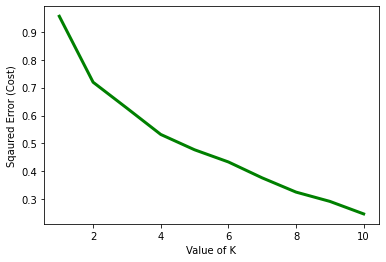

In [39]:
# Let's focus on the venues only
mum_grouped_clustering = mum_grouped.drop('Ward', 1)

# Let's gather the cost in a list
cost = []
# set range of clusters to search the optimal solution for

rangeofK = range(1,11)

for i in rangeofK:
    kclusters = i

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mum_grouped_clustering)

    # check cluster labels generated for each row in the dataframe
    # kmeans.labels_[0:10]
  
    cost.append(kmeans.inertia_)
  
# plot the cost against K values 
plt.plot(rangeofK, cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show()

To be doubly sure let's now use the Silhouette score to identify the best k. Silhouette needs at least two clusters to start with

In [40]:
sil = []
mum_grouped_clustering = mum_grouped.drop('Ward', 1)
rangeofK = range(2,11)

for i in rangeofK:
    kclusters = i

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, n_init=20, random_state=0).fit(mum_grouped_clustering)
    sil.append(silhouette_score(mum_grouped_clustering, kmeans.labels_, metric = 'euclidean'))

Let's plot the Silhouette Scores against K. It reaches its global maximum at the optimal K

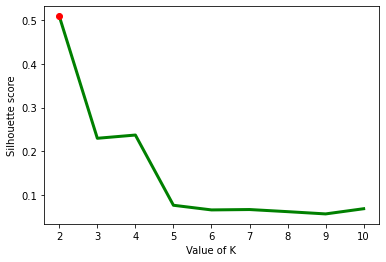

Max silhouette score: 0.5087196382912681 at k: 2


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [41]:
# Find the optimal K
npsil = np.array(sil)
kclusters = npsil.argmax() + 2 # We started with 2

# plot the Silhouette score against K
plt.plot(rangeofK, sil, color ='g', linewidth ='3')
plt.plot(kclusters, npsil.max(), 'ro')
plt.xlabel("Value of K") 
plt.ylabel("Silhouette score")
plt.show()

print("Max silhouette score:", npsil.max(), "at k:", npsil.argmax() + 2)

# run k-means clustering with optimal K
kmeans = KMeans(n_clusters=kclusters,random_state=0).fit(mum_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

In [42]:
v1, v2 = np.unique(kmeans.labels_, return_counts = True)
print(v1, v2)

[0 1] [23  1]


In [43]:
# add clustering labels

mum_sorted = mum_venues_sorted.copy()
mum_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

mum_merged = mum_upd_wards_tmp.copy()

# add latitude/longitude for each neighborhood
mum_merged = mum_merged.join(mum_sorted.set_index('Ward'), on='Ward')

display(mum_merged.head(2))

,Ward,Area,Land Area (SKM),Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A,Colaba,12.5,210847,18.915091,72.825969,0,Indian Restaurant,Café,Hotel,Bakery,Coffee Shop,Scenic Lookout,Cricket Ground,Italian Restaurant,Dessert Shop,Chinese Restaurant
1,B,Sanhurst Road,2.5,140633,18.956310,72.839838,0,Indian Restaurant,Dessert Shop,Ice Cream Shop,Café,Market,Restaurant,Chinese Restaurant,BBQ Joint,Garden,Cheese Shop


Let's find how the Wards have been clustered

In [44]:
mum_merged.groupby('Cluster Labels').Ward.count()

Cluster Labels
0    23
1     1
Name: Ward, dtype: int64

## **Maps to visualize the Wards and how they cluster together**

In [45]:
# Compute the centr of Mumbai for the map rather than go with the above
mum_lat = (MN_Lat + MS_Lat) / 2
mum_long = (ME_Long + MW_Long) / 2

# create map
map_mum_clusters = folium.Map(location=[mum_lat, mum_long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mum_merged['Latitude'], mum_merged['Longitude'], mum_merged['Ward'], mum_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_mum_clusters)
       
map_mum_clusters

**Here's a copy of the Folium map just in case you are not able to view the map shown above**
![](https://raw.githubusercontent.com/bala-viswanathan/Coursera_Capstone/master/Mumbai-Wards-By-Venue-Map.png)

Let's examine each cluster and determine the discriminating venue categories that distinguish each cluster

In [101]:
mum_merged.loc[mum_merged['Cluster Labels'] == 0, mum_merged.columns[[0] + list(range(7, mum_merged.shape[1]))]]

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A,Indian Restaurant,Café,Hotel,Bakery,Coffee Shop,Scenic Lookout,Cricket Ground,Italian Restaurant,Dessert Shop,Chinese Restaurant
1,B,Indian Restaurant,Dessert Shop,Ice Cream Shop,Café,Market,Restaurant,Chinese Restaurant,BBQ Joint,Garden,Cheese Shop
2,C,Indian Restaurant,Café,Fast Food Restaurant,Train Station,Coffee Shop,Juice Bar,Gastropub,Pizza Place,Ice Cream Shop,Indie Movie Theater
3,D,Indian Restaurant,Restaurant,Bakery,Bar,Coffee Shop,Snack Place,Chinese Restaurant,Park,Fast Food Restaurant,Vegetarian / Vegan Restaurant
4,E,Indian Restaurant,Café,Lounge,Chinese Restaurant,Restaurant,Coffee Shop,Hotel,Bar,Italian Restaurant,Multiplex
5,F South,Indian Restaurant,Fast Food Restaurant,Ice Cream Shop,Café,Coffee Shop,Italian Restaurant,Snack Place,Dessert Shop,Juice Bar,Pizza Place
6,F North,Indian Restaurant,Chinese Restaurant,Movie Theater,Deli / Bodega,Café,Tea Room,Gym / Fitness Center,Breakfast Spot,Seafood Restaurant,Flower Shop
7,G South,Indian Restaurant,Chinese Restaurant,Harbor / Marina,Bakery,Flower Shop,Fast Food Restaurant,Miscellaneous Shop,Convention Center,Gym,Plaza
8,G North,Boat or Ferry,Vegetarian / Vegan Restaurant,Train Station,Pizza Place,Tea Room,Scenic Lookout,Café,Indian Restaurant,Donut Shop,Field
9,H East,Café,Seafood Restaurant,Lounge,Indian Restaurant,Ice Cream Shop,Dessert Shop,Coffee Shop,Bar,Bakery,Chinese Restaurant


In [102]:
mum_merged.loc[mum_merged['Cluster Labels'] == 1, mum_merged.columns[[0] + list(range(7, mum_merged.shape[1]))]]

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,M East,Chinese Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Food,Women's Store,Flea Market,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant


Let's now look at COVID-19 data for Mumbai

Municipal Corporation of Greater Mumbai, publishes a COVID-19 dashboard at: 
http://stopcoronavirus.mcgm.gov.in/assets/docs/Dashboard.pdf
This is a graphically rich multi page document and does not lend itself to be scraped with any of the available PDF reader libraries. Hence, Ward level COVID-19 data is manually captured from this Dashboard onto a spreadsheet which in turn is being read into for further processing

In [49]:
# Read in COVID-19 Total cases distributed across wards
file = "./BMC-Ward-Split-17Sep2020.csv"
mum_cov_ward = pd.read_csv(file)

Let's convert 'Total Positive' into a numeric type and enable the use of the same for computation later and also drop Total Deaths for this exercise

In [50]:
mum_cov_ward['Total Positive'] = mum_cov_ward['Total Positive'].astype('int')
mum_cov_ward.drop('Total Deaths', axis = 1, inplace = True)

Here's a snapshot of the Mumbai's COVID-19 Data

In [51]:
display(mum_cov_ward)

,Ward,Total Positive
0,R Central,10927
1,P North,10548
2,K East,10517
3,K West,10475
4,G North,9704
5,R South,9272
6,S,9004
7,N,8871
8,T,7987
9,D,7848


Mumbai Ward information along with Total Positive case data are normalized using the Standard score method to ensure differences in the range of each of these features do not impact the model while training with these data.

Remove any categorical data so that normalization and further computation can be done

In [52]:
# Add COVID-19 total cases data to the ward information
mum_mov_cluster = mum_upd_wards_tmp.copy()
mum_mov_cluster = mum_mov_cluster.join(mum_cov_ward.set_index('Ward'), on='Ward')
mum_mov_cluster = mum_mov_cluster.drop('Ward', 1)
mum_mov_cluster = mum_mov_cluster.drop('Area', 1)

display(mum_mov_cluster.head(3))

# Ensure all the columns have float data
mum_mov_cluster = mum_mov_cluster.astype('float64')

# Extract data values only
x = mum_mov_cluster.values

# Use StdScaler and normalize the data
Stdscaler = preprocessing.StandardScaler()
xscaled = Stdscaler.fit_transform(x)

# Convert the above back to a DataFrame and 'Ward' back
mum_mov_cluster = pd.DataFrame(xscaled, columns = mum_mov_cluster.columns)
mum_mov_cluster['Ward'] = mum_upd_wards_tmp['Ward']

# Let's now include venue category information
mum_grp_cluster = mum_grouped.copy()

# Use Ward information to join both these DataFrames
mum_grp_cluster = mum_grouped.join(mum_mov_cluster.set_index('Ward'), on='Ward')
mum_grp_cluster = mum_grp_cluster.drop('Ward', axis=1)
display(mum_grp_cluster.shape)

,Land Area (SKM),Population,Latitude,Longitude,Total Positive
0,12.5,210847,18.915091,72.825969,4367
1,2.5,140633,18.956310,72.839838,1501
2,1.8,202922,18.945670,72.823781,2498


(24, 175)

Let's look at the merged and normalized data

In [53]:
display(mum_grp_cluster.head(2))
display(mum_grp_cluster.tail(2))

,Afghan Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Aquarium,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,...,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Wine Shop,Women's Store,Land Area (SKM),Population,Latitude,Longitude,Total Positive
0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.015873,0.015873,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.517330,-1.557781,-1.738687,-0.946599,-1.137843
1,0.0,0.0,0.0,0.0,0.025,0.0,0.025,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.196537,-1.937340,-1.291163,-0.553597,-2.303095


,Afghan Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Aquarium,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,...,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Wine Shop,Women's Store,Land Area (SKM),Population,Latitude,Longitude,Total Positive
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017544,0.0,...,0.000000,0.0,0.0,0.0,0.0,2.980588,1.039031,0.745209,2.240199,0.74746
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052632,0.0,...,0.052632,0.0,0.0,0.0,0.0,1.717263,-0.912616,1.053795,2.751295,0.33397


### Cluster Wards
Run *k*-means to cluster the Wards inclusive of COVID-19 Data into an optimal number of clusters

Let's try a range of clusters and compare the cost to identify the best k by usnig the elbow method

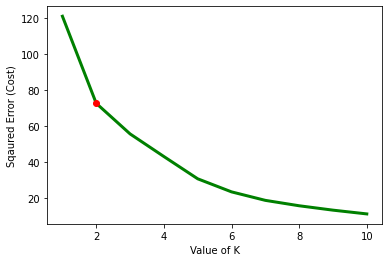

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [54]:
# Let's gather the cost in a list
cost = []
# set range of clusters to search the optimal solution for

rangeofK = range(1,11)

for i in rangeofK:
    kclusters = i

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mum_grp_cluster)

    # check cluster labels generated for each row in the dataframe
    # kmeans.labels_[0:10]
  
    cost.append(kmeans.inertia_)
  
# plot the cost against K values 
plt.plot(rangeofK, cost, color ='g', linewidth ='3')
# Elbow is at 2
kclusters = 2
plt.plot(kclusters, cost[1], 'ro')
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show()
# print(cost)

kclusters = 2
# run k-means clustering with optimal K
kmeans = KMeans(n_clusters=kclusters,random_state=0).fit(mum_grp_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

In [55]:
# del(mum_sorted_final)
mum_sorted_final = mum_venues_sorted.copy()
mum_sorted_final.insert(0, 'Cluster Labels', kmeans.labels_)
# mum_sorted_final.insert(0, 'Ward', mum_upd_wards_tmp['Ward'])
mum_sorted_final = mum_sorted_final.join(mum_upd_wards_tmp.set_index('Ward'), on='Ward')
mum_sorted_final = mum_sorted_final.join(mum_cov_ward.set_index('Ward'), on='Ward')

display(mum_sorted_final.head(2))
display(mum_sorted_final.tail(2))

,Cluster Labels,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Area,Land Area (SKM),Population,Latitude,Longitude,Total Positive
0,0,A,Indian Restaurant,Café,Hotel,Bakery,Coffee Shop,Scenic Lookout,Cricket Ground,Italian Restaurant,Dessert Shop,Chinese Restaurant,Colaba,12.5,210847,18.915091,72.825969,4367
1,0,B,Indian Restaurant,Dessert Shop,Ice Cream Shop,Café,Market,Restaurant,Chinese Restaurant,BBQ Joint,Garden,Cheese Shop,Sanhurst Road,2.5,140633,18.956310,72.839838,1501


,Cluster Labels,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Area,Land Area (SKM),Population,Latitude,Longitude,Total Positive
22,1,S,Indian Restaurant,Fast Food Restaurant,Snack Place,Coffee Shop,Restaurant,Pub,Café,Gym,Dessert Shop,Italian Restaurant,Bhandup,64.0,691227,19.143868,72.938433,9004
23,1,T,Café,Indian Restaurant,Golf Course,Asian Restaurant,Scenic Lookout,Residential Building (Apartment / Condo),Chinese Restaurant,Fast Food Restaurant,Dessert Shop,Pizza Place,Mulund,45.4,330195,19.172290,72.956469,7987


Let's find how the Wards have been clustered

In [56]:
mum_sorted_final.groupby('Cluster Labels').Ward.count()

Cluster Labels
0    12
1    12
Name: Ward, dtype: int64

## **Maps to visualize the Wards and how they cluster together**

In [57]:
# Compute the centr of Mumbai for the map rather than go with the above
mum_lat = (MN_Lat + MS_Lat) / 2
mum_long = (ME_Long + MW_Long) / 2

# create map
map_mum_clusters = folium.Map(location=[mum_lat, mum_long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, totpos in zip(mum_sorted_final['Latitude'], mum_sorted_final['Longitude'], mum_sorted_final['Ward'], mum_sorted_final['Cluster Labels'], mum_sorted_final['Total Positive']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + '\n +ve ' + str(totpos), parse_html=True)
    fcm = folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_mum_clusters)
       
map_mum_clusters

**Here's a copy of the Folium map just in case you are not able to view the map shown above**
![](https://raw.githubusercontent.com/bala-viswanathan/Coursera_Capstone/master/Mumbai-Wards-by-All-Map.png)

Let's examine each cluster and determine the discriminating venue categories that distinguish each cluster

In [59]:
mum_sorted_final.loc[mum_sorted_final['Cluster Labels'] == 0, mum_sorted_final.columns[[0] + list(range(1, mum_sorted_final.shape[1]))]]

,Cluster Labels,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Area,Land Area (SKM),Population,Latitude,Longitude,Total Positive
0,0,A,Indian Restaurant,Café,Hotel,Bakery,Coffee Shop,Scenic Lookout,Cricket Ground,Italian Restaurant,Dessert Shop,Chinese Restaurant,Colaba,12.5,210847,18.915091,72.825969,4367
1,0,B,Indian Restaurant,Dessert Shop,Ice Cream Shop,Café,Market,Restaurant,Chinese Restaurant,BBQ Joint,Garden,Cheese Shop,Sanhurst Road,2.5,140633,18.956310,72.839838,1501
2,0,C,Indian Restaurant,Café,Fast Food Restaurant,Train Station,Coffee Shop,Juice Bar,Gastropub,Pizza Place,Ice Cream Shop,Indie Movie Theater,Marine Lines,1.8,202922,18.945670,72.823781,2498
3,0,D,Indian Restaurant,Restaurant,Bakery,Bar,Coffee Shop,Snack Place,Chinese Restaurant,Park,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Grant Road,6.6,382841,18.964447,72.813573,7848
4,0,E,Indian Restaurant,Café,Lounge,Chinese Restaurant,Restaurant,Coffee Shop,Hotel,Bar,Italian Restaurant,Multiplex,Byculla,7.4,440335,18.976622,72.832794,6594
5,0,F North,Indian Restaurant,Chinese Restaurant,Movie Theater,Deli / Bodega,Café,Tea Room,Gym / Fitness Center,Breakfast Spot,Seafood Restaurant,Flower Shop,Matunga,13.0,524393,19.027436,72.850147,6794
6,0,F South,Indian Restaurant,Fast Food Restaurant,Ice Cream Shop,Café,Coffee Shop,Italian Restaurant,Snack Place,Dessert Shop,Juice Bar,Pizza Place,Parel,14.0,396122,19.009482,72.837661,7657
7,0,G North,Boat or Ferry,Vegetarian / Vegan Restaurant,Train Station,Pizza Place,Tea Room,Scenic Lookout,Café,Indian Restaurant,Donut Shop,Field,Dadar/Plaza,9.1,582007,19.023767,72.839403,9704
8,0,G South,Indian Restaurant,Chinese Restaurant,Harbor / Marina,Bakery,Flower Shop,Fast Food Restaurant,Miscellaneous Shop,Convention Center,Gym,Plaza,Elphinstone,10.0,457931,19.008427,72.842505,7134
9,0,H East,Café,Seafood Restaurant,Lounge,Indian Restaurant,Ice Cream Shop,Dessert Shop,Coffee Shop,Bar,Bakery,Chinese Restaurant,Khar/Santacruz,13.5,580835,19.083966,72.841699,5715


In [60]:
mum_sorted_final.loc[mum_sorted_final['Cluster Labels'] == 1, mum_sorted_final.columns[[0] + list(range(1, mum_sorted_final.shape[1]))]]

,Cluster Labels,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Area,Land Area (SKM),Population,Latitude,Longitude,Total Positive
11,1,K East,Indian Restaurant,Hotel,Italian Restaurant,Coffee Shop,Café,Lounge,Pizza Place,Multiplex,Brewery,Restaurant,Andheri (East),24.8,810002,19.115883,72.854202,10517
12,1,K West,Indian Restaurant,Gym,Italian Restaurant,Pub,Beach,Bakery,Mexican Restaurant,Ice Cream Shop,Chinese Restaurant,Donut Shop,Andheri (West),23.4,700680,19.117249,72.833968,10475
13,1,L,Indian Restaurant,Restaurant,Lounge,Café,Chinese Restaurant,Ice Cream Shop,Dessert Shop,Coffee Shop,Snack Place,Gym / Fitness Center,Kurla,15.9,778218,19.065280,72.879380,6935
14,1,M East,Chinese Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Food,Women's Store,Flea Market,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Chembur East,32.5,674850,19.046066,72.895473,5792
16,1,N,Indian Restaurant,Lounge,Italian Restaurant,Coffee Shop,Diner,Afghan Restaurant,Pub,Sandwich Place,Fast Food Restaurant,Brewery,Ghatkopar,26.0,619556,19.085954,72.908238,8871
17,1,P North,Fast Food Restaurant,Gym,Coffee Shop,Bookstore,Indian Restaurant,Seafood Restaurant,Multiplex,Pizza Place,Bar,Women's Store,Malad,19.1,796775,19.186719,72.848588,10548
18,1,P South,Indian Restaurant,Multiplex,Donut Shop,Chinese Restaurant,Shopping Mall,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Coffee Shop,Clothing Store,Breakfast Spot,Goregaon,24.4,437849,19.164803,72.850045,6282
19,1,R Central,Indian Restaurant,Chinese Restaurant,Juice Bar,Water Park,Restaurant,Sandwich Place,Theme Park,BBQ Joint,Seafood Restaurant,Dessert Shop,Borivali West,50.0,513077,19.229456,72.847990,10927
20,1,R North,Café,Chinese Restaurant,Indian Restaurant,Fast Food Restaurant,Restaurant,Department Store,Gym,Ice Cream Shop,Coffee Shop,Gym / Fitness Center,Dahiser,18.0,363827,19.253479,72.860903,5038
21,1,R South,Ice Cream Shop,Fast Food Restaurant,Pizza Place,Café,Indian Restaurant,Sandwich Place,Electronics Store,Restaurant,Lounge,Historic Site,Kandivalli,17.8,589886,19.201200,72.864332,9272


Let's find the number of venues of interest for each of the Wards

In [61]:
mog = mum_onehot.groupby('Ward').agg(np.sum).apply(np.sum, axis = 1)
mog = mog.to_frame().reset_index()
mog = mog.rename(columns= {0: 'Venue Count'})

Let's merge the above with the existing information on Wards and COVID-19 data

In [62]:
msf = mum_sorted_final.copy()
msf['Cases per Thousand'] = (msf['Total Positive'] / msf['Population']) * 1000
msf = msf.join(mog[['Ward', 'Venue Count']].set_index('Ward'), on='Ward')
msf = msf.join(mum_wards[['Ward', 'Density per Square Kilometer']].set_index('Ward'), on='Ward')
msf = msf.join(mum_wards[['Ward', 'Households']].set_index('Ward'), on='Ward', how = 'left')

Let's understand the correlation between various elements of the merged DataFrame for the two Clusters

In [63]:
cols = list(msf.columns); cols.remove('Cluster Labels')
display(msf[msf['Cluster Labels'] == 0][cols].corr())
display(msf[msf['Cluster Labels'] == 1][cols].corr())

,Land Area (SKM),Population,Latitude,Longitude,Total Positive,Cases per Thousand,Venue Count,Density per Square Kilometer,Households
Land Area (SKM),1.000000,0.488067,0.623841,0.687066,0.359996,0.086267,-0.167960,-0.810724,0.529158
Population,0.488067,1.000000,0.721909,0.255764,0.801797,-0.080497,-0.021931,-0.175974,0.991318
Latitude,0.623841,0.721909,1.000000,0.592389,0.368752,-0.409420,-0.204809,-0.340252,0.744746
Longitude,0.687066,0.255764,0.592389,1.000000,-0.040064,-0.447428,-0.551757,-0.436898,0.288599
Total Positive,0.359996,0.801797,0.368752,-0.040064,1.000000,0.488957,-0.061321,-0.212856,0.810690
Cases per Thousand,0.086267,-0.080497,-0.409420,-0.447428,0.488957,1.000000,0.096942,-0.290547,-0.053836
Venue Count,-0.167960,-0.021931,-0.204809,-0.551757,-0.061321,0.096942,1.000000,0.107010,-0.094219
Density per Square Kilometer,-0.810724,-0.175974,-0.340252,-0.436898,-0.212856,-0.290547,0.107010,1.000000,-0.219111
Households,0.529158,0.991318,0.744746,0.288599,0.810690,-0.053836,-0.094219,-0.219111,1.000000


,Land Area (SKM),Population,Latitude,Longitude,Total Positive,Cases per Thousand,Venue Count,Density per Square Kilometer,Households
Land Area (SKM),1.000000,-0.190204,0.089066,0.591850,0.206283,0.423978,-0.224989,-0.768153,-0.152535
Population,-0.190204,1.000000,-0.578437,-0.247047,0.456465,-0.641397,0.126580,0.695835,0.985300
Latitude,0.089066,-0.578437,1.000000,-0.238345,0.108754,0.589038,0.137968,-0.326764,-0.457240
Longitude,0.591850,-0.247047,-0.238345,1.000000,-0.235354,0.213626,-0.188650,-0.473226,-0.301950
Total Positive,0.206283,0.456465,0.108754,-0.235354,1.000000,0.345595,-0.143122,0.129556,0.565913
Cases per Thousand,0.423978,-0.641397,0.589038,0.213626,0.345595,1.000000,-0.307152,-0.600283,-0.556072
Venue Count,-0.224989,0.126580,0.137968,-0.188650,-0.143122,-0.307152,1.000000,0.303867,0.151468
Density per Square Kilometer,-0.768153,0.695835,-0.326764,-0.473226,0.129556,-0.600283,0.303867,1.000000,0.653618
Households,-0.152535,0.985300,-0.457240,-0.301950,0.565913,-0.556072,0.151468,0.653618,1.000000


We compare Clusters based on different features and also based on select features within a Cluster to unearth the similarities within a Cluster and differences between Clusters

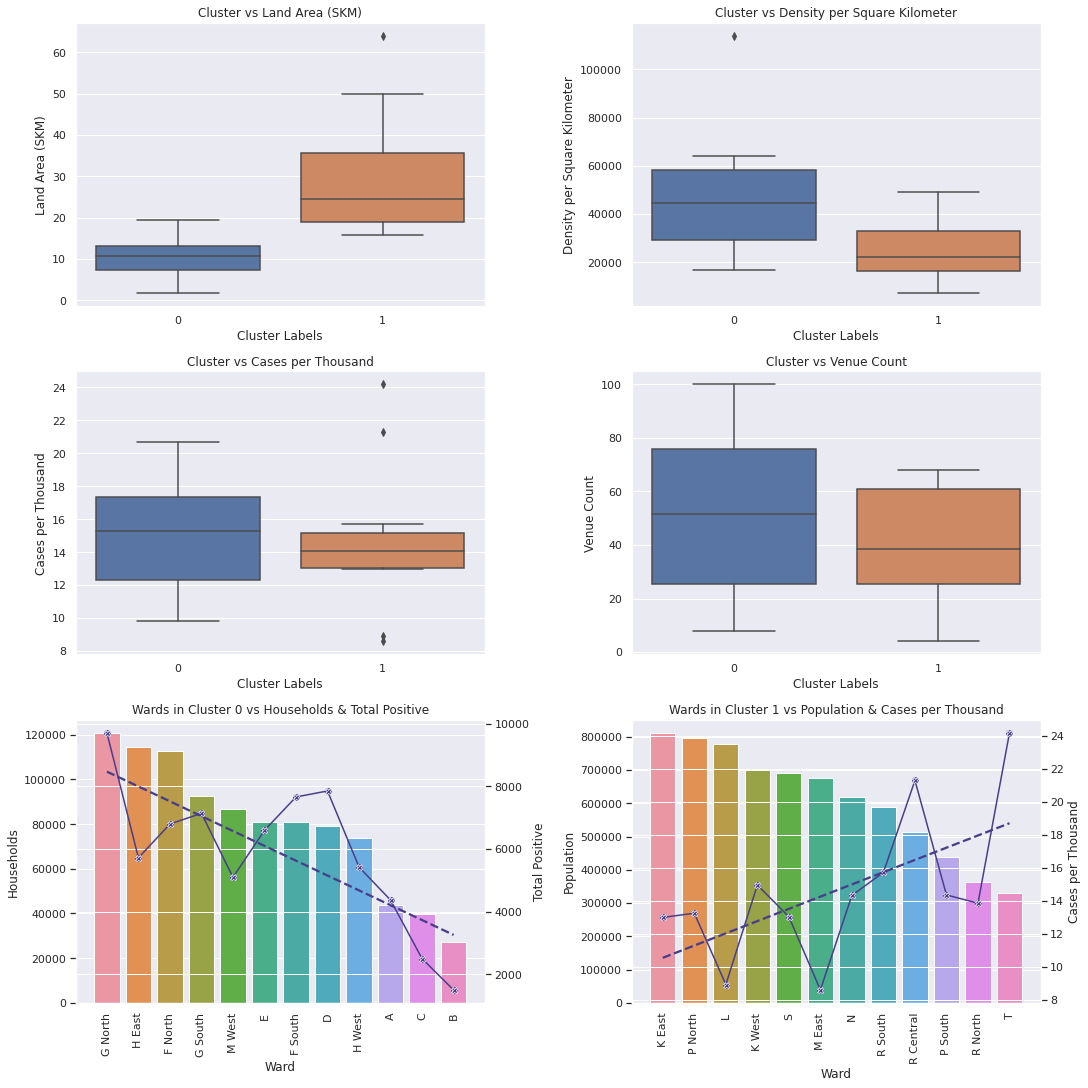

In [78]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                 

fig, ax = plt.subplots(3, 2, figsize=(15,15), constrained_layout=True)
sns.set()
# sns.set_palette(sns.color_palette("Set2"))

# sns.set(style = "ticks", color_codes = True)

red_diamond = dict(markerfacecolor='r', marker='D')

# Plot Graph 0,0
sns.boxplot(x = msf['Cluster Labels'], y = msf['Land Area (SKM)'], ax = ax[0, 0], orient = 'v')
ax[0,0].set_title("Cluster vs Land Area (SKM)")

# Plot Graph 0,1
sns.boxplot(x = msf['Cluster Labels'], y = msf['Density per Square Kilometer'], ax = ax[0, 1], orient = 'v')
ax[0,1].set_title("Cluster vs Density per Square Kilometer")

# Plot Graph 1,0
sns.boxplot(x = msf['Cluster Labels'], y = msf['Cases per Thousand'], ax = ax[1, 0], orient = 'v')
# ax[1,0].set_ylabel('Cases per Thousand')
ax[1,0].set_title("Cluster vs Cases per Thousand")

# Plot Graph 1,1
sns.boxplot(x = msf['Cluster Labels'], y = msf['Venue Count'], ax = ax[1, 1], orient = 'v')
ax[1,1].set_title("Cluster vs Venue Count")

wardinf = msf[['Ward', 'Cluster Labels', 'Land Area (SKM)', 'Population', 'Households', 'Density per Square Kilometer', 
               'Total Positive', 'Cases per Thousand']].copy()

# Plot Graph 2,0
wardinf = wardinf.sort_values(by='Households', ascending = False)
wi0 = wardinf[wardinf['Cluster Labels'] == 0]

wc_plt = sns.barplot(x = 'Ward', y = 'Households', data = wi0, ax = ax[2, 0])
ax2 = ax[2,0].twinx()
sns.lineplot(x = 'Ward', y = 'Total Positive', marker = 'X', data = wi0, color = 'darkslateblue', 
                     sort=False, ax = ax2)

xward = np.arange(len(wi0['Ward']))
sns.regplot(x = xward, y = wi0['Total Positive'], ax = ax2, color = 'darkslateblue', 
            ci = None, line_kws={"linestyle": "dashed"})

wc_plt.set_xticklabels(wc_plt.get_xticklabels(), rotation=90)
ax[2,0].set_title("Wards in Cluster 0 vs Households & Total Positive")

# Plot Graph 2.1
wardinf = wardinf.sort_values(by='Population', ascending = False)
wi1 = wardinf[wardinf['Cluster Labels'] == 1]

wc_plt = sns.barplot(x = 'Ward', y = 'Population', data = wi1, ax = ax[2, 1])
ax2 = ax[2,1].twinx()
sns.lineplot(x = 'Ward', y = 'Cases per Thousand', marker = 'X', data = wi1, color = 'darkslateblue', 
                     sort=False, ax = ax2)

xward = np.arange(len(wi1['Ward']))
sns.regplot(x = xward, y = wi1['Cases per Thousand'], ax = ax2, color = 'darkslateblue', 
            ci = None, line_kws={"linestyle": "dashed"})
                               
wc_plt.set_xticklabels(wc_plt.get_xticklabels(), rotation=90)
ax[2,1].set_title("Wards in Cluster 1 vs Population & Cases per Thousand")

# Show the plot
plt.show()

In [65]:
print("Aggregate population:", msf.groupby('Cluster Labels')['Population'].sum())
print()
print("Aggregate Positive:", msf.groupby('Cluster Labels')['Total Positive'].sum())
print()
print('Cases per Thousand for Cluster 0:', msf.groupby('Cluster Labels')['Total Positive'].sum()[0] / 
      msf.groupby('Cluster Labels')['Population'].sum()[0] * 1000)
print('Cases per Thousand for Cluster 1:', msf.groupby('Cluster Labels')['Total Positive'].sum()[1] / 
      msf.groupby('Cluster Labels')['Population'].sum()[1] * 1000)

Aggregate population: Cluster Labels
0    4670297
1    7306142
Name: Population, dtype: int64

Aggregate Positive: Cluster Labels
0     70326
1    101648
Name: Total Positive, dtype: int64

Cases per Thousand for Cluster 0: 15.058142983197856
Cases per Thousand for Cluster 1: 13.912677853783844


### Conclusion

#### Here are some observations from the above graphs
* Clusters are split based on the size of the land areas with smaller & the larger ones forming 0 and 1 respectively.
* Cluster 0 includes all the downtown locations with predominantly higher densities.
* Cluster 0: The Cases per Thousand per Ward is in the range of ~10 to ~21 i.e. 2X ratio between min and max.
* Cluster 1: The Cases per Thousand per Ward is in the range ~13 to ~16 i.e. a very limited band except for the outliers.
* There are more venues of interest in Cluster 0, as it includes all the downtown areas, than in Cluster 1.
* For Cluster 0, the Total Positive per Ward appears to relate more directly to size of the Households of the Wards.
* For Cluster 1, the Cases per Thousand appears to inversely relate to the size of the Population of the Wards.
* Information on the venues and their categories identified using the Foursquare API seem to provide sparse information.
* Venue Data, being sparse, appear to have had very little influence on the final outcome.
* The aggregate population size and the Total Positive Cases of Cluster 0 are less when compared with Cluster 1.
* Average number of Cases per Thousand per Ward is ~15 for Cluster 0 and ~14 for Cluster 1.

#### Here are some insights based on the above observations
* The spread of the virus is slightly more in Cluster 0 than Cluster 1.
* In Cluster 0, focus for combating the disease may be more along the lines of the number of Households i.e. Wards with more # of Households are prioritized over those with less.
* In Cluster 1, focus for combating the disease may be based on the size of the Population in an increasing order i.e. priortize Wards with lesser population over those with more.
* A more broader strategy may need to be followed to contain the spread in Cluster 0 as the Cases per Thousand per ward is in a wider range.
* A homogeneous approach may work well in containing the spread in Cluster 1 with outliers handled as appropriate.

#### Future Directions
* Recompute the Clusters by including Total Deaths per Ward as a new feature.
* Look at alternate source of Location Data and arrive at a better understanding of the relationship between Venues and the spread of COVID-19 in Mumbai.